In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings('ignore')

In [25]:
# Data Understanding and Preparation

In [57]:
# 1. Load the dataset
df = pd.read_excel('FBA_final_dataset.xlsx')

In [58]:
# 2. Basic info: missing values and descriptive stats
print("Missing values check:")
print(df.isnull().sum())
print("\nDescriptive statistics:")
print(df.describe())

Missing values check:
Country                0
GDP_Growth             0
Inflation              0
Political_Stability    0
Gov_Effectiveness      0
Current_Account        0
Unemployment           0
dtype: int64

Descriptive statistics:
       GDP_Growth  Inflation  Political_Stability  Gov_Effectiveness  \
count   14.000000  14.000000            14.000000          14.000000   
mean     7.657143   3.050000            47.223571           0.590714   
std     19.594336   1.498076            27.749910           0.922134   
min     -2.900000   0.200000             2.370000          -1.390000   
25%      0.975000   2.325000            23.342500          -0.117500   
50%      2.900000   3.050000            46.205000           0.885000   
75%      4.600000   4.400000            73.812500           1.212500   
max     75.100000   5.000000            88.150000           1.630000   

       Current_Account  Unemployment  
count        14.000000     14.000000  
mean          2.400000      7.121429  

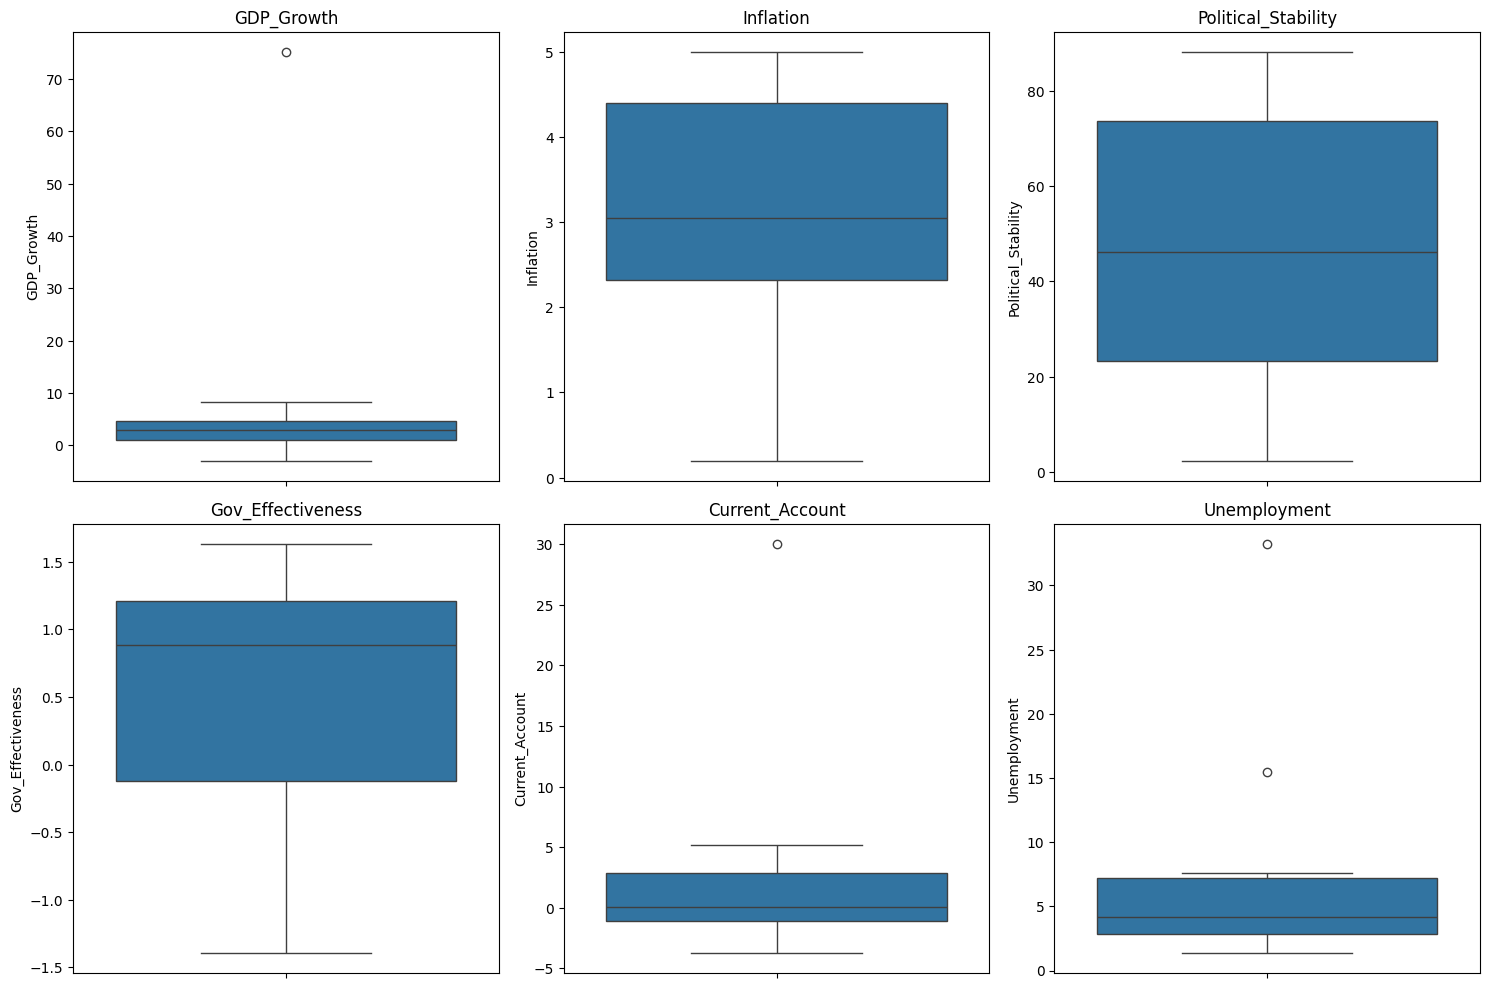

In [59]:
# 3. Visualize potential outliers with boxplots
plt.figure(figsize=(15, 10))
for i, column in enumerate(df.columns[1:]):
    plt.subplot(2, 3, i+1)
    sns.boxplot(y=df[column])
    plt.title(column)
plt.tight_layout()
plt.show()

In [60]:
# 4. Set Country as index for easier manipulation
df_processed = df.copy().set_index('Country')

# Z-score normalization
scaler_z = StandardScaler()
df_z_scaled = pd.DataFrame(
    scaler_z.fit_transform(df_processed),
    columns=df_processed.columns,
    index=df_processed.index
)

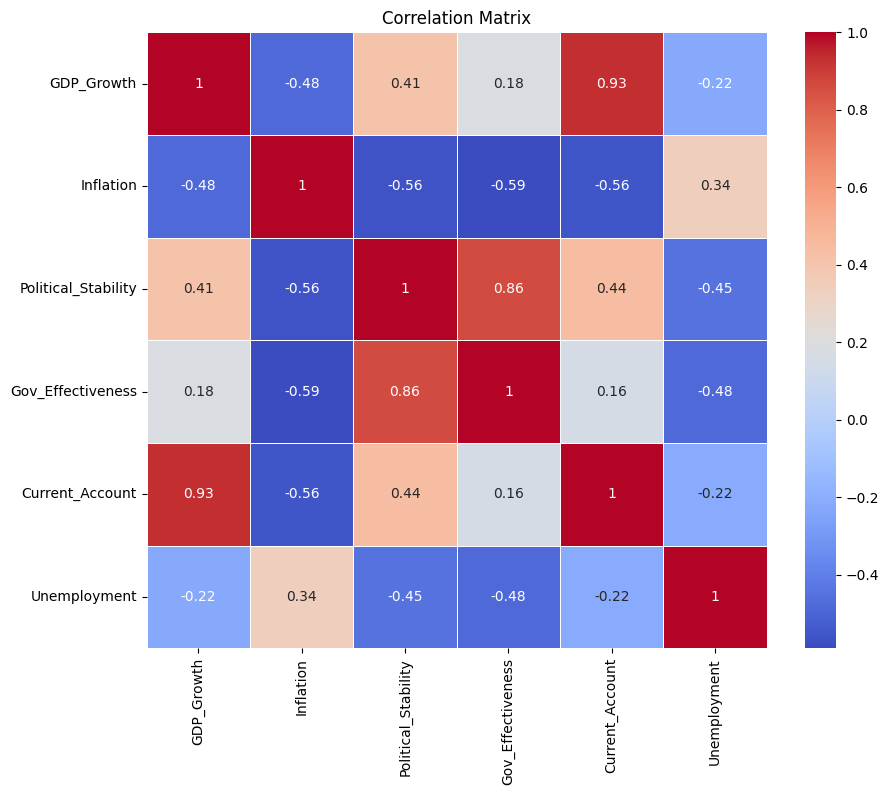

In [61]:
# 5. Generate correlation matrix and heatmap
plt.figure(figsize=(10, 8))
correlation_matrix = df_processed.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

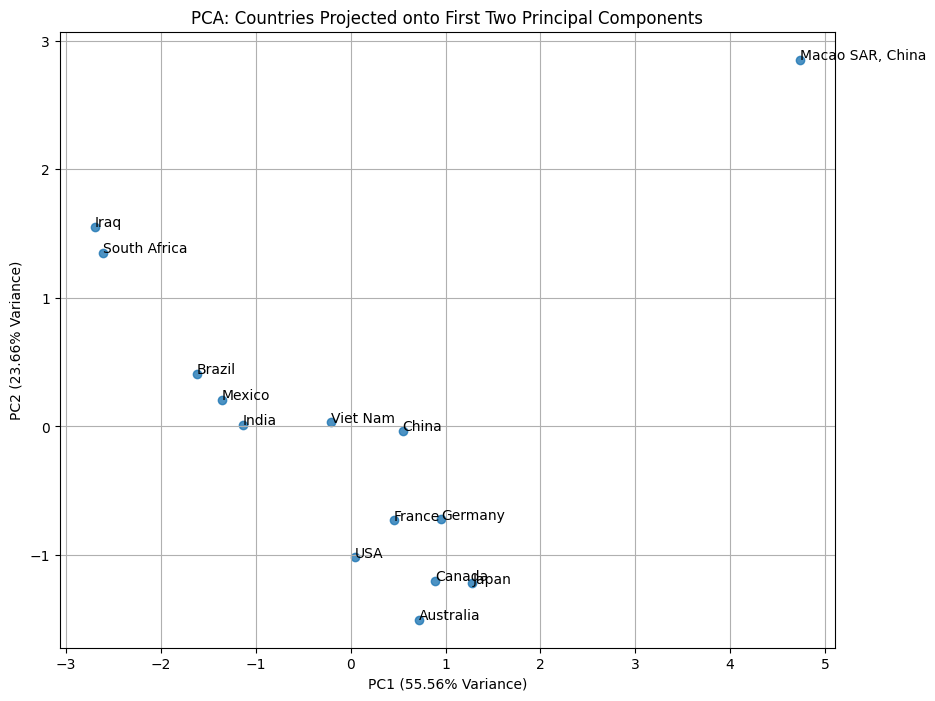

PCA components contribution:
                          PC1       PC2
GDP_Growth           0.398032  0.534656
Inflation           -0.440499  0.004563
Political_Stability  0.465133 -0.276410
Gov_Effectiveness    0.406279 -0.499196
Current_Account      0.409797  0.536665
Unemployment        -0.313347  0.317040


In [62]:
# 6. Apply PCA for dimensionality reduction
pca = PCA(n_components=2)
pca_result = pca.fit_transform(df_z_scaled)
df_pca = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'], index=df_processed.index)

# Visualize countries in PCA space
plt.figure(figsize=(10, 8))
plt.scatter(df_pca['PC1'], df_pca['PC2'], alpha=0.8)
for i, country in enumerate(df_pca.index):
    plt.annotate(country, (df_pca['PC1'][i], df_pca['PC2'][i]))
plt.title('PCA: Countries Projected onto First Two Principal Components')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.2f}% Variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.2f}% Variance)')
plt.grid(True)
plt.show()

# Check feature importance in principal components
pca_components = pd.DataFrame(
    pca.components_.T, 
    columns=['PC1', 'PC2'], 
    index=df_processed.columns
)
print("PCA components contribution:")
print(pca_components)

In [63]:
# 7. Define which variables need to be inverted (higher values = lower risk)
variables_to_invert = ['GDP_Growth', 'Political_Stability', 'Gov_Effectiveness', 'Current_Account']

# Create risk indicators based on Z-score (with inversions)
df_risk = df_z_scaled.copy()
for column in variables_to_invert:
    df_risk[column] = -df_risk[column]  # Invert so higher values = higher risk

# Define weights based on country risk assessment literature
weights = {
    'GDP_Growth': 0.20,         # Economic strength/resilience
    'Inflation': 0.15,          # Monetary stability
    'Political_Stability': 0.25, # Political environment
    'Gov_Effectiveness': 0.20,   # Institutional quality
    'Current_Account': 0.10,     # External position
    'Unemployment': 0.10         # Social stability
}

# Calculate weighted risk score
df_risk['Weighted_Score'] = sum(df_risk[column] * weight for column, weight in weights.items())

# Convert to 1-10 scale (higher = higher risk)
min_score = df_risk['Weighted_Score'].min()
max_score = df_risk['Weighted_Score'].max()
df_risk['Risk_Score_1_10'] = 1 + 9 * (df_risk['Weighted_Score'] - min_score) / (max_score - min_score)

Countries by Risk Score (1-10, higher = higher risk):
                  Risk_Score_1_10
Country                          
Iraq                    10.000000
South Africa             9.392177
Brazil                   8.420289
Mexico                   8.184953
India                    7.786156
Viet Nam                 6.801304
USA                      6.227269
China                    6.115707
France                   5.818494
Germany                  5.305859
Australia                5.167588
Canada                   5.108879
Japan                    4.703617
Macao SAR, China         1.000000


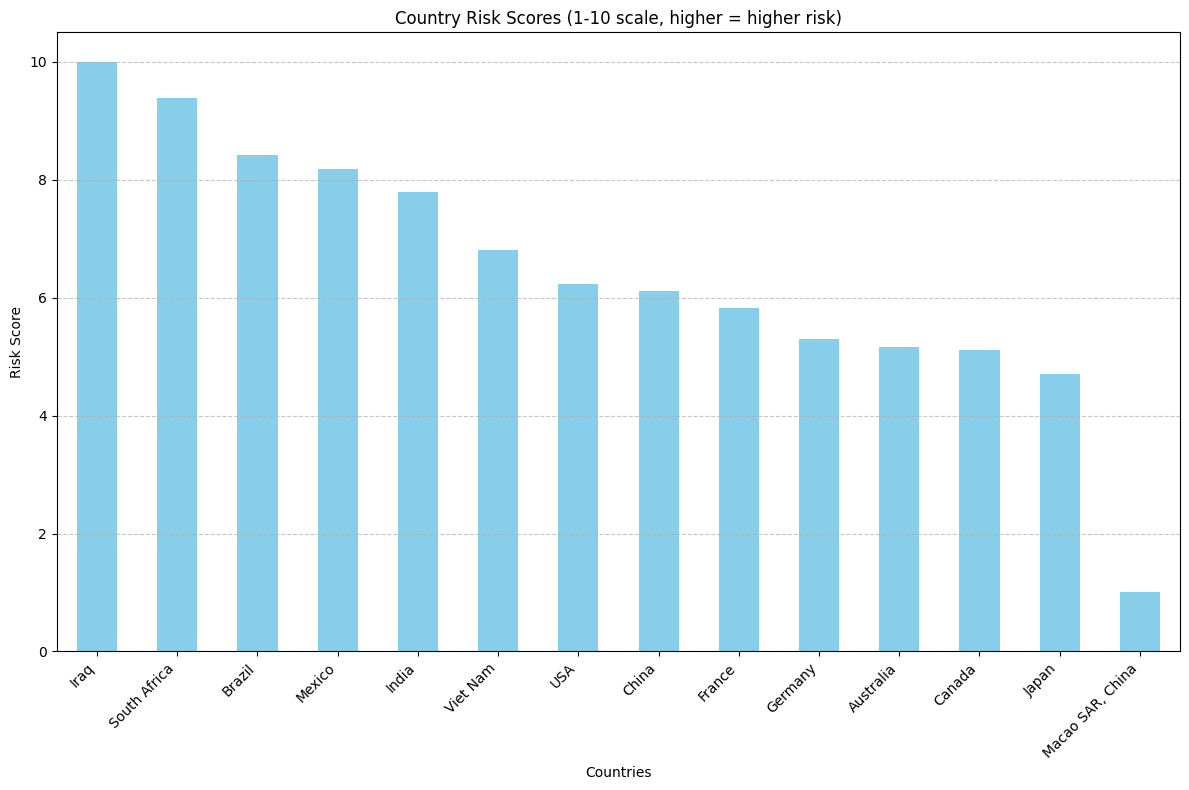

In [64]:
# 8. Sort countries by risk score
df_risk_sorted = df_risk.sort_values('Risk_Score_1_10', ascending=False)
print("Countries by Risk Score (1-10, higher = higher risk):")
print(df_risk_sorted[['Risk_Score_1_10']])

# Visualize risk scores
plt.figure(figsize=(12, 8))
df_risk_sorted['Risk_Score_1_10'].plot(kind='bar', color='skyblue')
plt.title('Country Risk Scores (1-10 scale, higher = higher risk)')
plt.xlabel('Countries')
plt.ylabel('Risk Score')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

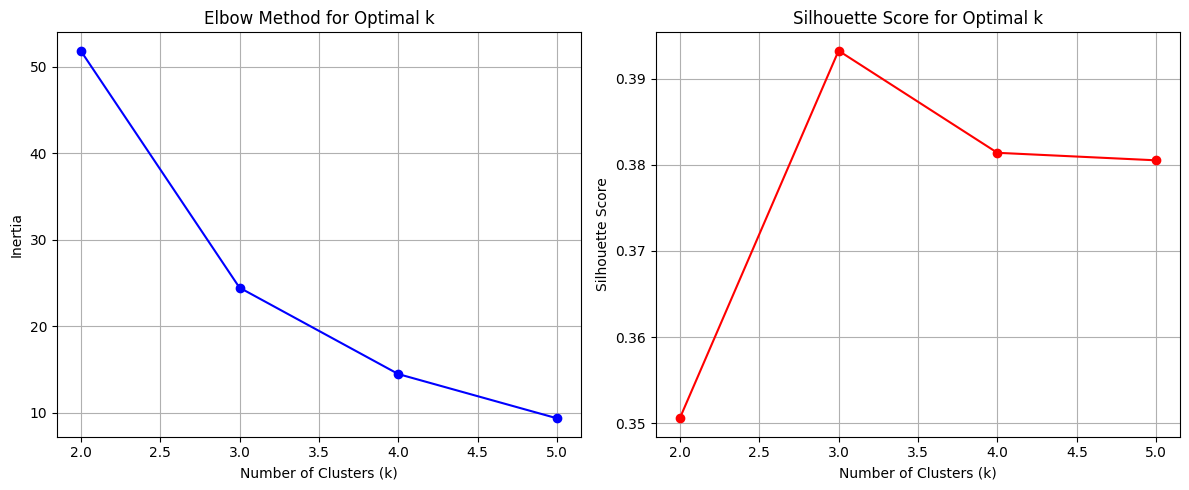

In [65]:
# 9. Use Z-score normalized data for clustering
X = df_z_scaled.values

# Find optimal number of clusters using the Elbow Method
inertia = []
silhouette_scores = []
k_range = range(2, 6)  # Testing 2-5 clusters

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X, kmeans.labels_))

# Plot Elbow Method results
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(k_range, inertia, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(k_range, silhouette_scores, 'ro-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Optimal k')
plt.grid(True)
plt.tight_layout()
plt.show()

In [66]:
# 10. Apply K-means with optimal number of clusters
optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X)

# Add cluster labels to the dataset
df_risk['Cluster'] = clusters

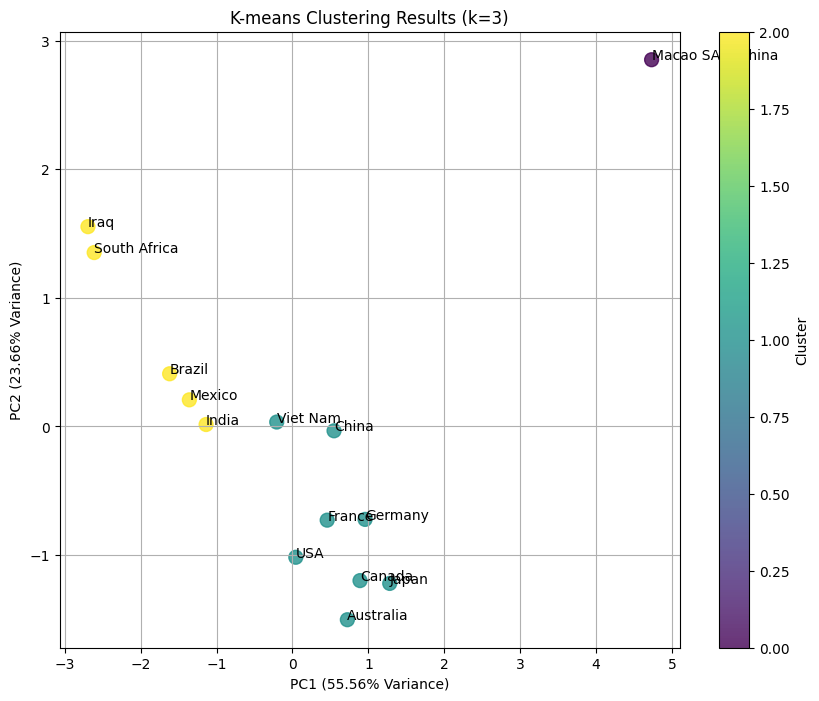

In [53]:
# 11. Visualize clusters in PCA space
plt.figure(figsize=(10, 8))
scatter = plt.scatter(df_pca['PC1'], df_pca['PC2'], c=clusters, cmap='viridis', s=100, alpha=0.8)
plt.colorbar(scatter, label='Cluster')
for i, country in enumerate(df_pca.index):
    plt.annotate(country, (df_pca['PC1'][i], df_pca['PC2'][i]))
plt.title(f'K-means Clustering Results (k={optimal_k})')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.2f}% Variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.2f}% Variance)')
plt.grid(True)
plt.show()

In [38]:
# Cluster Analysis
# 12. Add risk scores to the original data with cluster labels
cluster_analysis = df_processed.copy()
cluster_analysis['Cluster'] = clusters
cluster_analysis['Risk_Score'] = df_risk['Risk_Score_1_10']

# Analyze cluster characteristics
print("Cluster Analysis:")
for i in range(optimal_k):
    print(f"\nCluster {i}:")
    cluster_data = cluster_analysis[cluster_analysis['Cluster'] == i]
    print(f"Countries: {', '.join(cluster_data.index)}")
    print(f"Average Risk Score: {cluster_data['Risk_Score'].mean():.2f}")
    print("Cluster Characteristics:")
    print(cluster_data.mean())

Cluster Analysis:

Cluster 0:
Countries: Macao SAR, China
Average Risk Score: 1.00
Cluster Characteristics:
GDP_Growth             75.10
Inflation               0.50
Political_Stability    88.15
Gov_Effectiveness       1.09
Current_Account        30.00
Unemployment            2.40
Cluster                 0.00
Risk_Score              1.00
dtype: float64

Cluster 1:
Countries: China, USA, Germany, Japan, France, Canada, Viet Nam, Australia
Average Risk Score: 5.66
Cluster Characteristics:
GDP_Growth              2.50000
Inflation               2.41250
Political_Stability    59.65500
Gov_Effectiveness       1.13750
Current_Account         0.87500
Unemployment            4.26250
Cluster                 1.00000
Risk_Score              5.65609
dtype: float64

Cluster 2:
Countries: India, Brazil, South Africa, Iraq, Mexico
Average Risk Score: 8.76
Cluster Characteristics:
GDP_Growth              2.420000
Inflation               4.580000
Political_Stability    19.148000
Gov_Effectiveness      

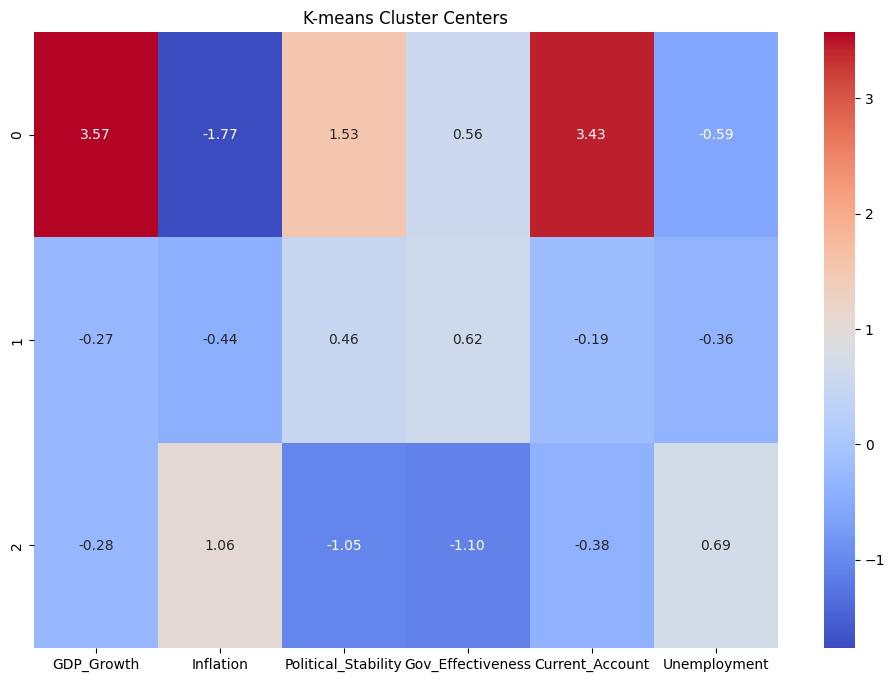

In [48]:
# 13. Heatmap of cluster centers
plt.figure(figsize=(12, 8))
cluster_centers = pd.DataFrame(kmeans.cluster_centers_, columns=df_processed.columns)
sns.heatmap(cluster_centers, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('K-means Cluster Centers')
plt.show()

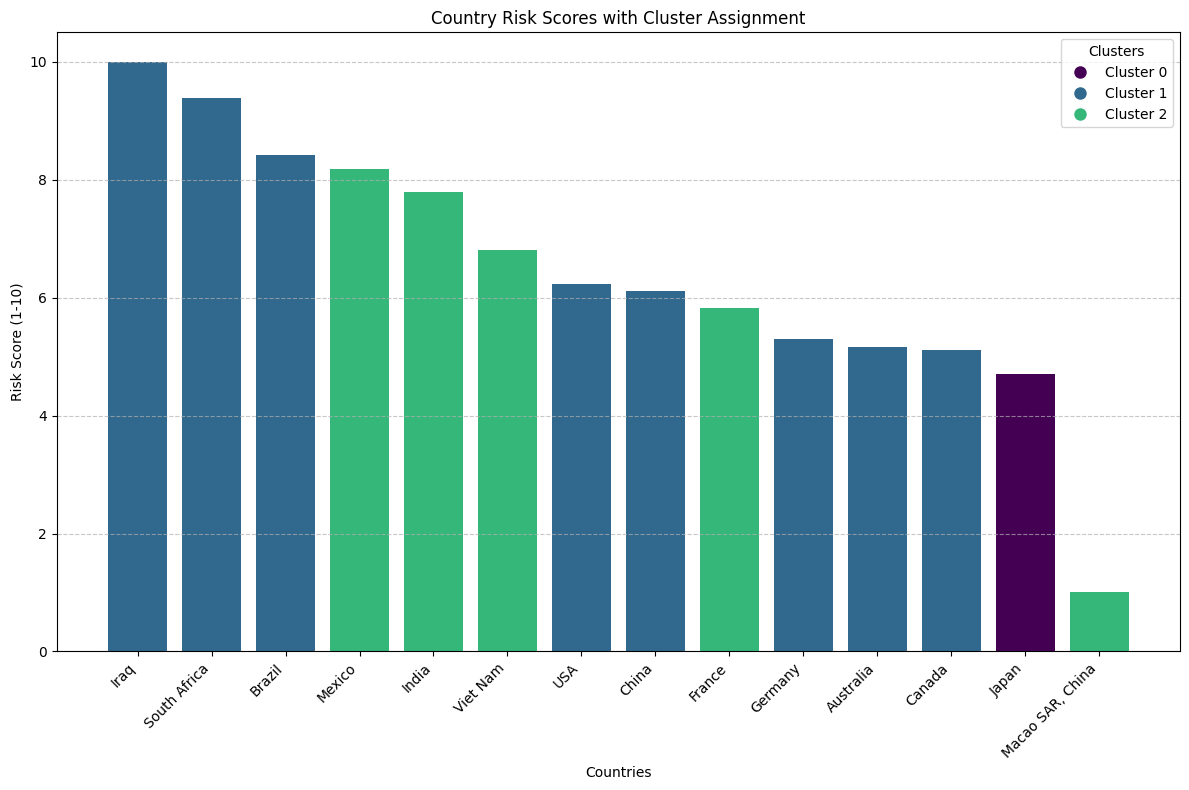

In [70]:
# 14. Combine risk scores and clusters in a single visualization
df_risk_sorted['Cluster'] = clusters

plt.figure(figsize=(12, 8))
bars = plt.bar(df_risk_sorted.index, df_risk_sorted['Risk_Score_1_10'], 
        color=[plt.cm.viridis(c/optimal_k) for c in df_risk_sorted['Cluster']])
plt.title('Country Risk Scores with Cluster Assignment')
plt.xlabel('Countries')
plt.ylabel('Risk Score (1-10)')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add a legend for clusters
legend_elements = [Line2D([0], [0], marker='o', color='w', 
                         markerfacecolor=plt.cm.viridis(c/optimal_k), markersize=10, 
                         label=f'Cluster {c}') for c in range(optimal_k)]
plt.legend(handles=legend_elements, title='Clusters')
plt.tight_layout()
plt.show()

In [55]:
# 15. Portfolio allocation by risk category based on clusters and risk scores
portfolio_total = 300  # $300 million

# Define allocation percentages
allocations = {
    "Low Risk": 0.60,    # 60% to low risk countries
    "Moderate Risk": 0.30,  # 30% to moderate risk countries
    "High Risk": 0.10    # 10% to high risk countries
}

# Calculate allocation amounts
for risk_level, percentage in allocations.items():
    print(f"{risk_level}: ${portfolio_total * percentage:.1f} million ({percentage*100:.0f}%)")

Low Risk: $180.0 million (60%)
Moderate Risk: $90.0 million (30%)
High Risk: $30.0 million (10%)
